<a href="https://colab.research.google.com/github/Jorgepratesn/Projetos/blob/main/An%C3%A1lise_Troca_Passes(SNA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparação da base

In [ ]:
!pip install mplsoccer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from mplsoccer import Pitch, Sbopen
from mplsoccer import VerticalPitch,Pitch

In [ ]:
#Jogos Campeonato Espanhol 2015/16
parser = Sbopen()
match_data = parser.match(competition_id=11, season_id=27)
lista_match_id = match_data['match_id'].tolist()
dfs_merged = []

for match_id in lista_match_id:
    df, _, _, tactics = parser.event(match_id=match_id)
    df = df[df.type_name == 'Pass']
    df = df[['match_id','x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name", "team_name", "minute", 'player_id']]
    tactics = tactics[['jersey_number', 'player_id']]
    df_merged = pd.merge(df, tactics, on='player_id', how='left')
    dfs_merged.append(df_merged)
df_final = pd.concat(dfs_merged, ignore_index=True)


#Análise Barcelona

In [ ]:
Team = 'Barcelona'
df_barca = df_final[df_final.team_name == Team]

# Filtrar jogadores com mais de 18 jogos (metade) e que começou pelo menos um jogo como titular
player_df = df_final[df_final.team_name == Team].groupby('player_name').agg({'minute': [min, max]}).reset_index()
player_df = pd.concat([player_df['player_name'], player_df['minute']], axis=1)
player_df['minutes_played'] = player_df['max'] - player_df['min']
match_count = df_final[df_final['team_name'] == Team].groupby('player_name')['match_id'].nunique().reset_index()
match_count.columns = ['player_name', 'unique_match_count']
player_df = player_df.merge(match_count, on='player_name', how='left')
player_df = player_df.sort_values('unique_match_count', ascending=False)
player_df = player_df.loc[(player_df['min'] == 0) & (player_df['unique_match_count'] >= 18)]

In [ ]:
#Calcula tamanho do marker levando em conta a quantidade de passess e localização de cada jogador
scatter_df = pd.DataFrame()
for i, name in enumerate(df_barca["player_name"].unique()):
    passx = df_barca.loc[df_barca["player_name"] == name]["x"].to_numpy()
    recx = df_barca.loc[df_barca["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_barca.loc[df_barca["player_name"] == name]["y"].to_numpy()
    recy = df_barca.loc[df_barca["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #média do local dos passes dados
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #número de passes
    scatter_df.at[i, "no"] = df_barca.loc[df_barca["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = df_barca.loc[df_barca["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'].fillna(0, inplace=True)
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)
    #Filtrar jogadores
    scatter_df = scatter_df.merge(player_df[['player_name']], on='player_name', how='inner')

#ajustar tamanho do circulo
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [ ]:
#Calcular largura da linha
df_barca_filtrado = df_barca[df_barca['player_name'].isin(player_df['player_name'])]
df_barca_filtrado = df_barca_filtrado[df_barca_filtrado['pass_recipient_name'].isin(player_df['player_name'])]
df_barca_filtrado["pair_key"] = df_barca_filtrado.apply(lambda x: "_".join(sorted([str(x["player_name"]), str(x["pass_recipient_name"])])), axis=1)
lines_df = df_barca_filtrado.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#somente jogadores com mais de 5 passes trocados
lines_df = lines_df[lines_df['pass_count']>5]

In [ ]:
#Criando uma base para calculo dos indicadores SNA
df_selected = df_barca_filtrado[['player_name', 'pass_recipient_name', 'pair_key']]
pair_key_counts = df_selected['pair_key'].value_counts().reset_index()
pair_key_counts.columns = ['pair_key', 'count']
df_SNA = df_selected.drop_duplicates()
df_SNA = pd.merge(df_SNA, pair_key_counts, on='pair_key', how='left')
df_SNA = df_SNA.loc[:, ['player_name', 'pass_recipient_name', 'count']]


In [ ]:
# Criar um grafo direcionado a partir dos dados
G = nx.DiGraph()

# Adicionar as arestas com os pesos
for index, row in df_SNA.iterrows():
    G.add_edge(row['player_name'], row['pass_recipient_name'], weight=row['count'])

# Calcular a centralidade de intermediação
betweenness_directed = nx.betweenness_centrality(G, weight='weight', normalized=False)
# Calcular a centralidade de grau ponderado
weighted_degree = nx.degree(G, weight='weight')
# Calcular a centralidade de closeness
closeness_directed = nx.closeness_centrality(G, distance='weight')
# Calcular a cluster coefficient
cluster_coeficiente = nx.clustering(G, weight='weight')

#Adicionar no scatter_df
weighted_degree_map = dict(weighted_degree)
scatter_df['marker_size_degree'] = scatter_df['player_name'].map(weighted_degree_map)
scatter_df['marker_size_degree'] = scatter_df['marker_size_degree'] / 10
closeness_directed_map = dict(closeness_directed)
scatter_df['marker_size_closeness'] = scatter_df['player_name'].map(closeness_directed_map)
scatter_df['marker_size_closeness'] = scatter_df['marker_size_closeness']*100000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
betweenness_directed_map = dict(betweenness_directed)
scatter_df['marker_size_betweenness'] = scatter_df['player_name'].map(betweenness_directed_map)
scatter_df['marker_size_betweenness'] = scatter_df['marker_size_betweenness']*100

In [ ]:
# Metricas de rede
# Densidade
num_nodes = G.number_of_nodes()
def normalize_edge_weights(graph):
  max_weight = max(d['weight'] for u, v, d in graph.edges(data=True))
  normalized_weights = [d['weight'] / max_weight for u, v, d in graph.edges(data=True)]
  return normalized_weights
normalized_edge_weights = normalize_edge_weights(G)
total_normalized_weight = sum(normalized_edge_weights)
density_ponderada_barca = total_normalized_weight / (num_nodes * (num_nodes - 1))
# Comprimento médio do caminho
average_path_length_barca = nx.average_shortest_path_length(G,weight='weight')

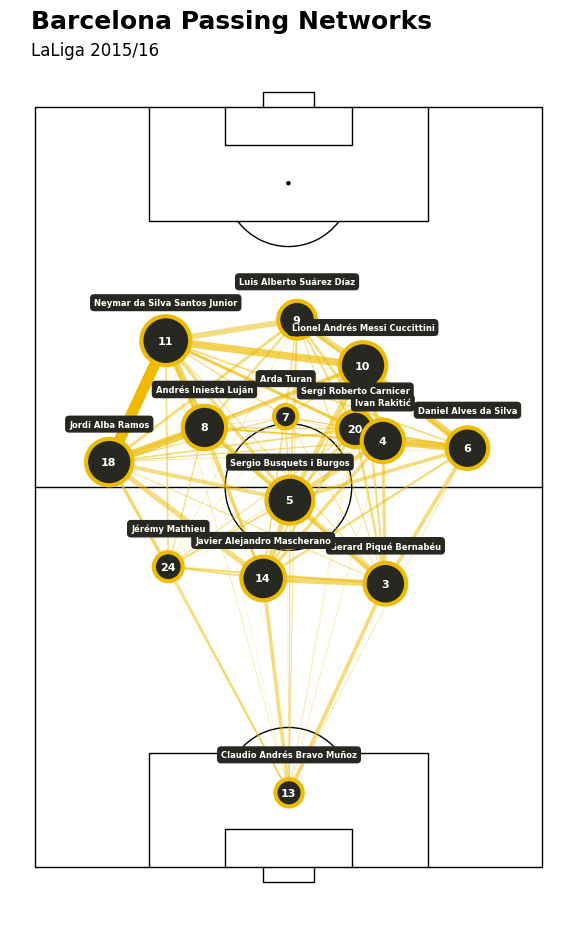

In [ ]:
pitch = VerticalPitch(pitch_type='statsbomb', line_color='black',linewidth=1,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# plotar vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size_degree, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax["pitch"], zorder = 3)

# Adicionar numero da camisa e nome do jogador
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))

for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plotar bordas
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #localização média dos jogadores
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #largura da linha
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # Ajustar o alfa das linhas com base no número de passes e definir um alfa mínimo para um número menor de passes
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plotar linhas no campo
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax["pitch"])

fig.text(s=Team + " "+ "Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='LaLiga 2015/16', x = 0.06, y=0.97, fontsize=12)
plt.show()

#Análise Real Madrid

In [ ]:
Team = 'Real Madrid'
df_real = df_final[df_final.team_name == Team]

# Filtrar jogadores com mais de 18 jogos (metade) e que começou pelo menos um jogo como titular
player_df = df_final[df_final.team_name == Team].groupby('player_name').agg({'minute': [min, max]}).reset_index()
player_df = pd.concat([player_df['player_name'], player_df['minute']], axis=1)
player_df['minutes_played'] = player_df['max'] - player_df['min']
match_count = df_final[df_final['team_name'] == Team].groupby('player_name')['match_id'].nunique().reset_index()
match_count.columns = ['player_name', 'unique_match_count']
player_df = player_df.merge(match_count, on='player_name', how='left')
player_df = player_df.sort_values('unique_match_count', ascending=False)
player_df = player_df.loc[(player_df['min'] == 0) & (player_df['unique_match_count'] >= 18)]


In [ ]:
#Calcula tamanho do marker levando em conta a quantidade de passess e localização de cada jogador
scatter_df = pd.DataFrame()
for i, name in enumerate(df_real["player_name"].unique()):
    passx = df_real.loc[df_real["player_name"] == name]["x"].to_numpy()
    recx = df_real.loc[df_real["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_real.loc[df_real["player_name"] == name]["y"].to_numpy()
    recy = df_real.loc[df_real["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #média do local dos passes dados
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #número de passes
    scatter_df.at[i, "no"] = df_real.loc[df_real["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = df_real.loc[df_real["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'].fillna(0, inplace=True)
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)
    #Filtrar jogadores
    scatter_df = scatter_df.merge(player_df[['player_name']], on='player_name', how='inner')

#ajustar tamanho do circulo
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [ ]:
#Calcular largura
df_real_filtrado = df_real[df_real['player_name'].isin(player_df['player_name'])]
df_real_filtrado = df_real_filtrado[df_real_filtrado['pass_recipient_name'].isin(player_df['player_name'])]
df_real_filtrado["pair_key"] = df_real_filtrado.apply(lambda x: "_".join(sorted([str(x["player_name"]), str(x["pass_recipient_name"])])), axis=1)
lines_df = df_real_filtrado.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#somente jogadores com mais de 5 passes trocados
lines_df = lines_df[lines_df['pass_count']>5]

In [ ]:
#Criando uma base para calculo dos indicadores SNA
df_selected = df_real_filtrado[['player_name', 'pass_recipient_name', 'pair_key']]
pair_key_counts = df_selected['pair_key'].value_counts().reset_index()
pair_key_counts.columns = ['pair_key', 'count']
df_SNA = df_selected.drop_duplicates()
df_SNA = pd.merge(df_SNA, pair_key_counts, on='pair_key', how='left')
df_SNA = df_SNA.loc[:, ['player_name', 'pass_recipient_name', 'count']]


In [ ]:
# Criar um grafo direcionado a partir dos dados
G = nx.DiGraph()

# Adicionar as arestas com os pesos
for index, row in df_SNA.iterrows():
    G.add_edge(row['player_name'], row['pass_recipient_name'], weight=row['count'])

# Calcular a centralidade de intermediação
betweenness_directed = nx.betweenness_centrality(G, weight='weight', normalized=False)
# Calcular a centralidade de grau ponderado
weighted_degree = nx.degree(G, weight='weight')
# Calcular a centralidade de closeness
closeness_directed = nx.closeness_centrality(G, distance='weight')
# Calcular a cluster coefficient
cluster_coeficiente = nx.clustering(G, weight='weight')

#Adicionar no scatter_df
weighted_degree_map = dict(weighted_degree)
scatter_df['marker_size_degree'] = scatter_df['player_name'].map(weighted_degree_map)
scatter_df['marker_size_degree'] = scatter_df['marker_size_degree'] / 10
closeness_directed_map = dict(closeness_directed)
scatter_df['marker_size_closeness'] = scatter_df['player_name'].map(closeness_directed_map)
scatter_df['marker_size_closeness'] = scatter_df['marker_size_closeness']*100000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
betweenness_directed_map = dict(betweenness_directed)
scatter_df['marker_size_betweenness'] = scatter_df['player_name'].map(betweenness_directed_map)
scatter_df['marker_size_betweenness'] = scatter_df['marker_size_betweenness']*100

In [ ]:
# Metricas de rede
# Densidade
num_nodes = G.number_of_nodes()
def normalize_edge_weights(graph):
  max_weight = max(d['weight'] for u, v, d in graph.edges(data=True))
  normalized_weights = [d['weight'] / max_weight for u, v, d in graph.edges(data=True)]
  return normalized_weights
normalized_edge_weights = normalize_edge_weights(G)
total_normalized_weight = sum(normalized_edge_weights)
density_ponderada_real = total_normalized_weight / (num_nodes * (num_nodes - 1))
# Comprimento médio do caminho
average_path_length_real = nx.average_shortest_path_length(G,weight='weight')

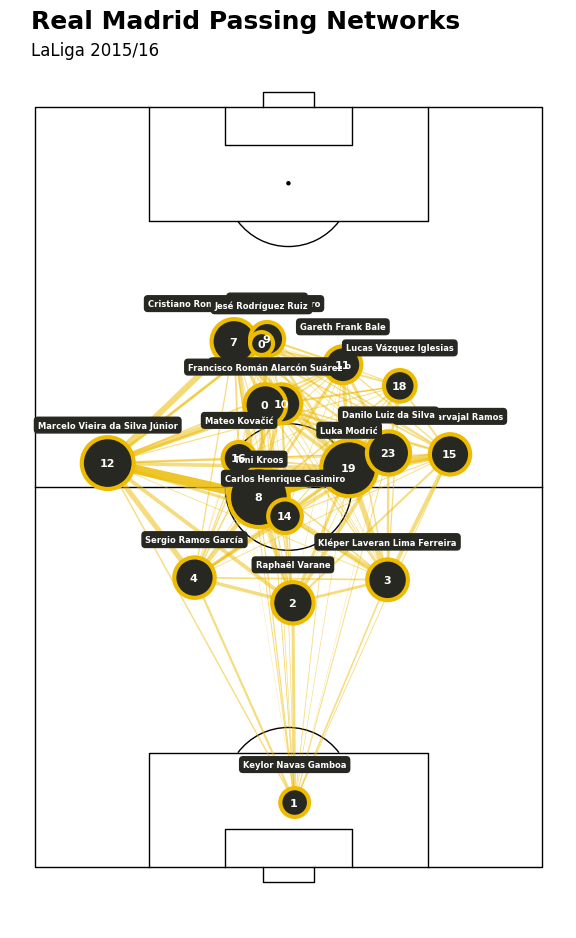

In [ ]:
pitch = VerticalPitch(pitch_type='statsbomb', line_color='black',linewidth=1,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# plotar vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size_degree, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax["pitch"], zorder = 3)

# Adicionar numero da camisa e nome do jogador
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))

for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plotar bordas
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #localização média dos jogadores
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #largura da linha
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # Ajustar o alfa das linhas com base no número de passes e definir um alfa mínimo para um número menor de passes
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plotar linhas no campo
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax["pitch"])

fig.text(s=Team + " "+ "Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='LaLiga 2015/16', x = 0.06, y=0.97, fontsize=12)
plt.show()

#Análise Atletico Madrid

In [ ]:
Team = 'Atlético Madrid'
df_atleti = df_final[df_final.team_name == Team]

# Filtrar jogadores com mais de 18 jogos (metade) e que começou pelo menos um jogo como titular
player_df = df_final[df_final.team_name == Team].groupby('player_name').agg({'minute': [min, max]}).reset_index()
player_df = pd.concat([player_df['player_name'], player_df['minute']], axis=1)
player_df['minutes_played'] = player_df['max'] - player_df['min']
match_count = df_final[df_final['team_name'] == Team].groupby('player_name')['match_id'].nunique().reset_index()
match_count.columns = ['player_name', 'unique_match_count']
player_df = player_df.merge(match_count, on='player_name', how='left')
player_df = player_df.sort_values('unique_match_count', ascending=False)
player_df = player_df.loc[(player_df['min'] == 0) & (player_df['unique_match_count'] >= 18)]


In [ ]:
#Calcula tamanho do marker levando em conta a quantidade de passess e localização de cada jogador
scatter_df = pd.DataFrame()
for i, name in enumerate(df_atleti["player_name"].unique()):
    passx = df_atleti.loc[df_atleti["player_name"] == name]["x"].to_numpy()
    recx = df_atleti.loc[df_atleti["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_atleti.loc[df_atleti["player_name"] == name]["y"].to_numpy()
    recy = df_atleti.loc[df_atleti["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #média do local dos passes dados
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #número de passes
    scatter_df.at[i, "no"] = df_atleti.loc[df_atleti["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = df_atleti.loc[df_atleti["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'].fillna(0, inplace=True)
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)
    #Filtrar jogadores
    scatter_df = scatter_df.merge(player_df[['player_name']], on='player_name', how='inner')

#ajustar tamanho do circulo
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [ ]:
#Calcular largura
df_atleti_filtrado = df_atleti[df_atleti['player_name'].isin(player_df['player_name'])]
df_atleti_filtrado = df_atleti_filtrado[df_atleti_filtrado['pass_recipient_name'].isin(player_df['player_name'])]
df_atleti_filtrado["pair_key"] = df_atleti_filtrado.apply(lambda x: "_".join(sorted([str(x["player_name"]), str(x["pass_recipient_name"])])), axis=1)
lines_df = df_atleti_filtrado.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#somente jogadores com mais de 5 passes trocados
lines_df = lines_df[lines_df['pass_count']>5]

In [ ]:
#Criando uma base para calculo dos indicadores SNA
df_selected = df_atleti_filtrado[['player_name', 'pass_recipient_name', 'pair_key']]
pair_key_counts = df_selected['pair_key'].value_counts().reset_index()
pair_key_counts.columns = ['pair_key', 'count']
df_SNA = df_selected.drop_duplicates()
df_SNA = pd.merge(df_SNA, pair_key_counts, on='pair_key', how='left')
df_SNA = df_SNA.loc[:, ['player_name', 'pass_recipient_name', 'count']]


In [ ]:
# Criar um grafo direcionado a partir dos dados
G = nx.DiGraph()

# Adicionar as arestas com os pesos
for index, row in df_SNA.iterrows():
    G.add_edge(row['player_name'], row['pass_recipient_name'], weight=row['count'])

# Calcular a centralidade de intermediação
betweenness_directed = nx.betweenness_centrality(G, weight='weight', normalized=False)
# Calcular a centralidade de grau ponderado
weighted_degree = nx.degree(G, weight='weight')
# Calcular a centralidade de closeness
closeness_directed = nx.closeness_centrality(G, distance='weight')
# Calcular a cluster coefficient
cluster_coeficiente = nx.clustering(G, weight='weight')

#Adicionar no scatter_df
weighted_degree_map = dict(weighted_degree)
scatter_df['marker_size_degree'] = scatter_df['player_name'].map(weighted_degree_map)
scatter_df['marker_size_degree'] = scatter_df['marker_size_degree'] / 10
closeness_directed_map = dict(closeness_directed)
scatter_df['marker_size_closeness'] = scatter_df['player_name'].map(closeness_directed_map)
scatter_df['marker_size_closeness'] = scatter_df['marker_size_closeness']*100000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
betweenness_directed_map = dict(betweenness_directed)
scatter_df['marker_size_betweenness'] = scatter_df['player_name'].map(betweenness_directed_map)
scatter_df['marker_size_betweenness'] = scatter_df['marker_size_betweenness']*100

In [ ]:
# Metricas de rede
# Densidade
num_nodes = G.number_of_nodes()
def normalize_edge_weights(graph):
  max_weight = max(d['weight'] for u, v, d in graph.edges(data=True))
  normalized_weights = [d['weight'] / max_weight for u, v, d in graph.edges(data=True)]
  return normalized_weights
normalized_edge_weights = normalize_edge_weights(G)
total_normalized_weight = sum(normalized_edge_weights)
density_ponderada_atlet = total_normalized_weight / (num_nodes * (num_nodes - 1))
# Comprimento médio do caminho
average_path_length_atlet = nx.average_shortest_path_length(G,weight='weight')

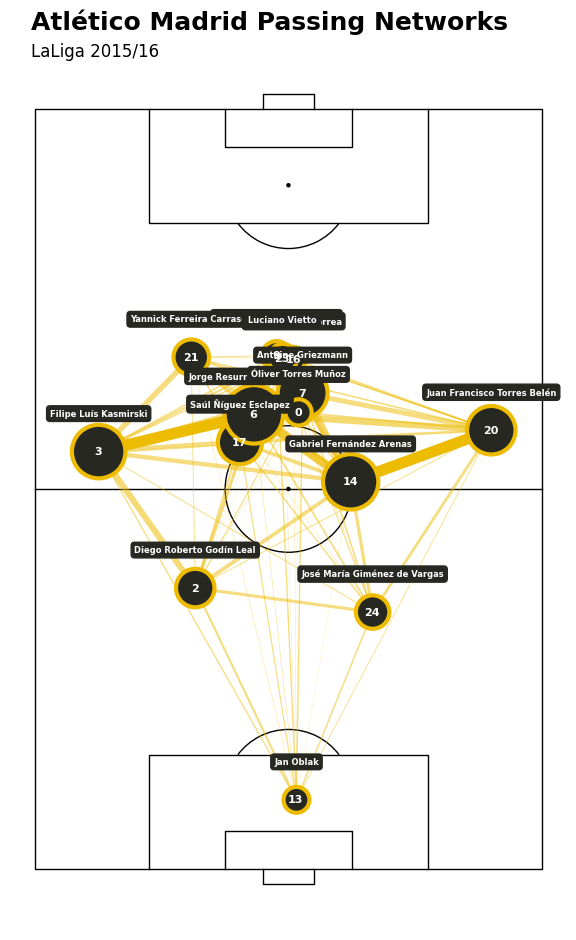

In [ ]:
pitch = VerticalPitch(pitch_type='statsbomb', line_color='black',linewidth=1,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# plotar vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size_degree, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax["pitch"], zorder = 3)

# Adicionar numero da camisa e nome do jogador
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))

for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plotar bordas
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #localização média dos jogadores
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #largura da linha
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # Ajustar o alfa das linhas com base no número de passes e definir um alfa mínimo para um número menor de passes
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plotar linhas no campo
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax["pitch"])

fig.text(s=Team + " "+ "Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='LaLiga 2015/16', x = 0.06, y=0.97, fontsize=12)
plt.show()

#Análise Getafe

In [ ]:
Team = 'Getafe'
df_Getafe = df_final[df_final.team_name == Team]

# Filtrar jogadores com mais de 18 jogos (metade) e que começou pelo menos um jogo como titular
player_df = df_final[df_final.team_name == Team].groupby('player_name').agg({'minute': [min, max]}).reset_index()
player_df = pd.concat([player_df['player_name'], player_df['minute']], axis=1)
player_df['minutes_played'] = player_df['max'] - player_df['min']
match_count = df_final[df_final['team_name'] == Team].groupby('player_name')['match_id'].nunique().reset_index()
match_count.columns = ['player_name', 'unique_match_count']
player_df = player_df.merge(match_count, on='player_name', how='left')
player_df = player_df.sort_values('unique_match_count', ascending=False)
player_df = player_df.loc[(player_df['min'] == 0) & (player_df['unique_match_count'] >= 18)]


In [ ]:
#Calcula tamanho do marker levando em conta a quantidade de passess e localização de cada jogador
scatter_df = pd.DataFrame()
for i, name in enumerate(df_Getafe["player_name"].unique()):
    passx = df_Getafe.loc[df_Getafe["player_name"] == name]["x"].to_numpy()
    recx = df_Getafe.loc[df_Getafe["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_Getafe.loc[df_Getafe["player_name"] == name]["y"].to_numpy()
    recy = df_Getafe.loc[df_Getafe["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #média do local dos passes dados
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #número de passes
    scatter_df.at[i, "no"] = df_Getafe.loc[df_Getafe["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = df_Getafe.loc[df_Getafe["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'].fillna(0, inplace=True)
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)
    #Filtrar jogadores
    scatter_df = scatter_df.merge(player_df[['player_name']], on='player_name', how='inner')

#ajustar tamanho do circulo
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [ ]:
#Calcular largura
df_Getafe_filtrado = df_Getafe[df_Getafe['player_name'].isin(player_df['player_name'])]
df_Getafe_filtrado = df_Getafe_filtrado[df_Getafe_filtrado['pass_recipient_name'].isin(player_df['player_name'])]
df_Getafe_filtrado["pair_key"] = df_Getafe_filtrado.apply(lambda x: "_".join(sorted([str(x["player_name"]), str(x["pass_recipient_name"])])), axis=1)
lines_df = df_Getafe_filtrado.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#somente jogadores com mais de 5 passes trocados
lines_df = lines_df[lines_df['pass_count']>5]

In [ ]:
#Criando uma base para calculo dos indicadores SNA
df_selected = df_Getafe_filtrado[['player_name', 'pass_recipient_name', 'pair_key']]
pair_key_counts = df_selected['pair_key'].value_counts().reset_index()
pair_key_counts.columns = ['pair_key', 'count']
df_SNA = df_selected.drop_duplicates()
df_SNA = pd.merge(df_SNA, pair_key_counts, on='pair_key', how='left')
df_SNA = df_SNA.loc[:, ['player_name', 'pass_recipient_name', 'count']]


In [ ]:
# Criar um grafo direcionado a partir dos dados
G = nx.DiGraph()

# Adicionar as arestas com os pesos
for index, row in df_SNA.iterrows():
    G.add_edge(row['player_name'], row['pass_recipient_name'], weight=row['count'])

# Calcular a centralidade de intermediação
betweenness_directed = nx.betweenness_centrality(G, weight='weight', normalized=False)
# Calcular a centralidade de grau ponderado
weighted_degree = nx.degree(G, weight='weight')
# Calcular a centralidade de closeness
closeness_directed = nx.closeness_centrality(G, distance='weight')
# Calcular a cluster coefficient
cluster_coeficiente = nx.clustering(G, weight='weight')

#Adicionar no scatter_df
weighted_degree_map = dict(weighted_degree)
scatter_df['marker_size_degree'] = scatter_df['player_name'].map(weighted_degree_map)
scatter_df['marker_size_degree'] = scatter_df['marker_size_degree'] / 10
closeness_directed_map = dict(closeness_directed)
scatter_df['marker_size_closeness'] = scatter_df['player_name'].map(closeness_directed_map)
scatter_df['marker_size_closeness'] = scatter_df['marker_size_closeness']*100000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
betweenness_directed_map = dict(betweenness_directed)
scatter_df['marker_size_betweenness'] = scatter_df['player_name'].map(betweenness_directed_map)
scatter_df['marker_size_betweenness'] = scatter_df['marker_size_betweenness']*100

In [ ]:
# Metricas de rede
# Densidade
num_nodes = G.number_of_nodes()
def normalize_edge_weights(graph):
  max_weight = max(d['weight'] for u, v, d in graph.edges(data=True))
  normalized_weights = [d['weight'] / max_weight for u, v, d in graph.edges(data=True)]
  return normalized_weights
normalized_edge_weights = normalize_edge_weights(G)
total_normalized_weight = sum(normalized_edge_weights)
density_ponderada_getafe = total_normalized_weight / (num_nodes * (num_nodes - 1))
# Comprimento médio do caminho
average_path_length_getafe = nx.average_shortest_path_length(G,weight='weight')

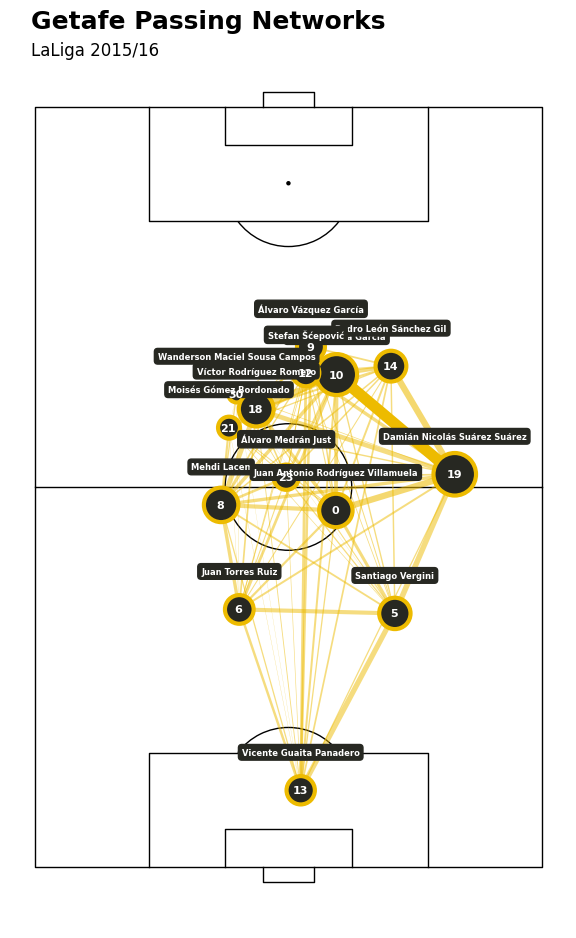

In [ ]:
pitch = VerticalPitch(pitch_type='statsbomb', line_color='black',linewidth=1,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# plotar vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size_degree, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax["pitch"], zorder = 3)

# Adicionar numero da camisa e nome do jogador
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))

for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plotar bordas
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #localização média dos jogadores
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #largura da linha
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # Ajustar o alfa das linhas com base no número de passes e definir um alfa mínimo para um número menor de passes
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plotar linhas no campo
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax["pitch"])

fig.text(s=Team + " "+ "Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='LaLiga 2015/16', x = 0.06, y=0.97, fontsize=12)
plt.show()

#Análise Rayo Vallecano

In [ ]:
Team = 'Rayo Vallecano'
df_rayo = df_final[df_final.team_name == Team]

# Filtrar jogadores com mais de 18 jogos (metade) e que começou pelo menos um jogo como titular
player_df = df_final[df_final.team_name == Team].groupby('player_name').agg({'minute': [min, max]}).reset_index()
player_df = pd.concat([player_df['player_name'], player_df['minute']], axis=1)
player_df['minutes_played'] = player_df['max'] - player_df['min']
match_count = df_final[df_final['team_name'] == Team].groupby('player_name')['match_id'].nunique().reset_index()
match_count.columns = ['player_name', 'unique_match_count']
player_df = player_df.merge(match_count, on='player_name', how='left')
player_df = player_df.sort_values('unique_match_count', ascending=False)
player_df = player_df.loc[(player_df['min'] == 0) & (player_df['unique_match_count'] >= 18)]


In [ ]:
#Calcula tamanho do marker levando em conta a quantidade de passess e localização de cada jogador
scatter_df = pd.DataFrame()
for i, name in enumerate(df_rayo["player_name"].unique()):
    passx = df_rayo.loc[df_rayo["player_name"] == name]["x"].to_numpy()
    recx = df_rayo.loc[df_rayo["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_rayo.loc[df_rayo["player_name"] == name]["y"].to_numpy()
    recy = df_rayo.loc[df_rayo["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #média do local dos passes dados
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #número de passes
    scatter_df.at[i, "no"] = df_rayo.loc[df_rayo["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = df_rayo.loc[df_rayo["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'].fillna(0, inplace=True)
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)
    #Filtrar jogadores
    scatter_df = scatter_df.merge(player_df[['player_name']], on='player_name', how='inner')

#ajustar tamanho do circulo
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [ ]:
#Calcular largura
df_rayo_filtrado = df_rayo[df_rayo['player_name'].isin(player_df['player_name'])]
df_rayo_filtrado = df_rayo_filtrado[df_rayo_filtrado['pass_recipient_name'].isin(player_df['player_name'])]
df_rayo_filtrado["pair_key"] = df_rayo_filtrado.apply(lambda x: "_".join(sorted([str(x["player_name"]), str(x["pass_recipient_name"])])), axis=1)
lines_df = df_rayo_filtrado.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#somente jogadores com mais de 5 passes trocados
lines_df = lines_df[lines_df['pass_count']>5]

In [ ]:
#Criando uma base para calculo dos indicadores SNA
df_selected = df_rayo_filtrado[['player_name', 'pass_recipient_name', 'pair_key']]
pair_key_counts = df_selected['pair_key'].value_counts().reset_index()
pair_key_counts.columns = ['pair_key', 'count']
df_SNA = df_selected.drop_duplicates()
df_SNA = pd.merge(df_SNA, pair_key_counts, on='pair_key', how='left')
df_SNA = df_SNA.loc[:, ['player_name', 'pass_recipient_name', 'count']]

In [ ]:
# Criar um grafo direcionado a partir dos dados
G = nx.DiGraph()

# Adicionar as arestas com os pesos
for index, row in df_SNA.iterrows():
    G.add_edge(row['player_name'], row['pass_recipient_name'], weight=row['count'])

# Calcular a centralidade de intermediação
betweenness_directed = nx.betweenness_centrality(G, weight='weight', normalized=False)
# Calcular a centralidade de grau ponderado
weighted_degree = nx.degree(G, weight='weight')
# Calcular a centralidade de closeness
closeness_directed = nx.closeness_centrality(G, distance='weight')
# Calcular a cluster coefficient
cluster_coeficiente = nx.clustering(G, weight='weight')

#Adicionar no scatter_df
weighted_degree_map = dict(weighted_degree)
scatter_df['marker_size_degree'] = scatter_df['player_name'].map(weighted_degree_map)
scatter_df['marker_size_degree'] = scatter_df['marker_size_degree'] / 10
closeness_directed_map = dict(closeness_directed)
scatter_df['marker_size_closeness'] = scatter_df['player_name'].map(closeness_directed_map)
scatter_df['marker_size_closeness'] = scatter_df['marker_size_closeness']*100000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
betweenness_directed_map = dict(betweenness_directed)
scatter_df['marker_size_betweenness'] = scatter_df['player_name'].map(betweenness_directed_map)
scatter_df['marker_size_betweenness'] = scatter_df['marker_size_betweenness']*100


In [ ]:
# Metricas de rede
# Densidade
num_nodes = G.number_of_nodes()
def normalize_edge_weights(graph):
  max_weight = max(d['weight'] for u, v, d in graph.edges(data=True))
  normalized_weights = [d['weight'] / max_weight for u, v, d in graph.edges(data=True)]
  return normalized_weights
normalized_edge_weights = normalize_edge_weights(G)
total_normalized_weight = sum(normalized_edge_weights)
density_ponderada_rayo = total_normalized_weight / (num_nodes * (num_nodes - 1))
# Comprimento médio do caminho
average_path_length_rayo = nx.average_shortest_path_length(G,weight='weight')

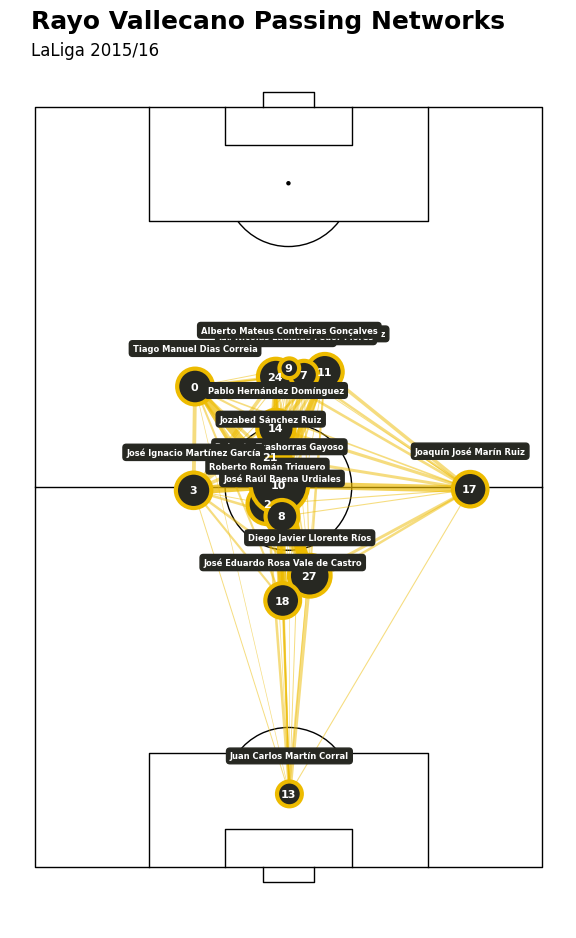

In [ ]:
pitch = VerticalPitch(pitch_type='statsbomb', line_color='black',linewidth=1,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# plotar vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size_degree, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax["pitch"], zorder = 3)

# Adicionar numero da camisa e nome do jogador
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))

for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plotar bordas
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #localização média dos jogadores
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #largura da linha
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # Ajustar o alfa das linhas com base no número de passes e definir um alfa mínimo para um número menor de passes
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plotar linhas no campo
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax["pitch"])

fig.text(s=Team + " "+ "Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='LaLiga 2015/16', x = 0.06, y=0.97, fontsize=12)
plt.show()

#Análise Levante

In [ ]:
Team = 'Levante UD'
df_levante = df_final[df_final.team_name == Team]

# Filtrar jogadores com mais de 18 jogos (metade) e que começou pelo menos um jogo como titular
player_df = df_final[df_final.team_name == Team].groupby('player_name').agg({'minute': [min, max]}).reset_index()
player_df = pd.concat([player_df['player_name'], player_df['minute']], axis=1)
player_df['minutes_played'] = player_df['max'] - player_df['min']
match_count = df_final[df_final['team_name'] == Team].groupby('player_name')['match_id'].nunique().reset_index()
match_count.columns = ['player_name', 'unique_match_count']
player_df = player_df.merge(match_count, on='player_name', how='left')
player_df = player_df.sort_values('unique_match_count', ascending=False)
player_df = player_df.loc[(player_df['min'] == 0) & (player_df['unique_match_count'] >= 18)]


In [ ]:
#Calcula tamanho e localização de cada jogador
scatter_df = pd.DataFrame()
for i, name in enumerate(df_levante["player_name"].unique()):
    passx = df_levante.loc[df_levante["player_name"] == name]["x"].to_numpy()
    recx = df_levante.loc[df_levante["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_levante.loc[df_levante["player_name"] == name]["y"].to_numpy()
    recy = df_levante.loc[df_levante["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #média do local dos passes dados
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #número de passes
    scatter_df.at[i, "no"] = df_levante.loc[df_levante["player_name"] == name].count().iloc[0]
    scatter_df.at[i, "jersey_number"] = df_levante.loc[df_levante["player_name"] == name]['jersey_number'].iloc[0]
    scatter_df['jersey_number'].fillna(0, inplace=True)
    scatter_df['jersey_number'] = scatter_df['jersey_number'].astype(int)
    #Filtrar jogadores
    scatter_df = scatter_df.merge(player_df[['player_name']], on='player_name', how='inner')

#ajustar tamanho do circulo
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [ ]:
#Calcular largura
df_levante_filtrado = df_levante[df_levante['player_name'].isin(player_df['player_name'])]
df_levante_filtrado = df_levante_filtrado[df_levante_filtrado['pass_recipient_name'].isin(player_df['player_name'])]
df_levante_filtrado["pair_key"] = df_levante_filtrado.apply(lambda x: "_".join(sorted([str(x["player_name"]), str(x["pass_recipient_name"])])), axis=1)
lines_df = df_levante_filtrado.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#somente jogadores com mais de 5 passes trocados
lines_df = lines_df[lines_df['pass_count']>5]

In [ ]:
#Criando uma base para calculo dos indicadores SNA
df_selected = df_levante_filtrado[['player_name', 'pass_recipient_name', 'pair_key']]
pair_key_counts = df_selected['pair_key'].value_counts().reset_index()
pair_key_counts.columns = ['pair_key', 'count']
df_SNA = df_selected.drop_duplicates()
df_SNA = pd.merge(df_SNA, pair_key_counts, on='pair_key', how='left')
df_SNA = df_SNA.loc[:, ['player_name', 'pass_recipient_name', 'count']]

In [ ]:
# Criar um grafo direcionado a partir dos dados
G = nx.DiGraph()

# Adicionar as arestas com os pesos
for index, row in df_SNA.iterrows():
    G.add_edge(row['player_name'], row['pass_recipient_name'], weight=row['count'])

# Calcular a centralidade de intermediação
betweenness_directed = nx.betweenness_centrality(G, weight='weight', normalized=False)
# Calcular a centralidade de grau ponderado
weighted_degree = nx.degree(G, weight='weight')
# Calcular a centralidade de closeness
closeness_directed = nx.closeness_centrality(G, distance='weight')
# Calcular a cluster coefficient
cluster_coeficiente = nx.clustering(G, weight='weight')

#Adicionar no scatter_df
weighted_degree_map = dict(weighted_degree)
scatter_df['marker_size_degree'] = scatter_df['player_name'].map(weighted_degree_map)
scatter_df['marker_size_degree'] = scatter_df['marker_size_degree'] / 10
closeness_directed_map = dict(closeness_directed)
scatter_df['marker_size_closeness'] = scatter_df['player_name'].map(closeness_directed_map)
scatter_df['marker_size_closeness'] = scatter_df['marker_size_closeness']*100000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
cluster_directed_map = dict(cluster_coeficiente)
scatter_df['marker_size_cluster'] = scatter_df['player_name'].map(cluster_directed_map)
scatter_df['marker_size_cluster'] = scatter_df['marker_size_cluster']*5000
betweenness_directed_map = dict(betweenness_directed)
scatter_df['marker_size_betweenness'] = scatter_df['player_name'].map(betweenness_directed_map)
scatter_df['marker_size_betweenness'] = scatter_df['marker_size_betweenness']*100


In [ ]:
# Metricas de rede
# Densidade
num_nodes = G.number_of_nodes()
def normalize_edge_weights(graph):
  max_weight = max(d['weight'] for u, v, d in graph.edges(data=True))
  normalized_weights = [d['weight'] / max_weight for u, v, d in graph.edges(data=True)]
  return normalized_weights
normalized_edge_weights = normalize_edge_weights(G)
total_normalized_weight = sum(normalized_edge_weights)
density_ponderada_levante = total_normalized_weight / (num_nodes * (num_nodes - 1))
# Comprimento médio do caminho
average_path_length_levante = nx.average_shortest_path_length(G,weight='weight')

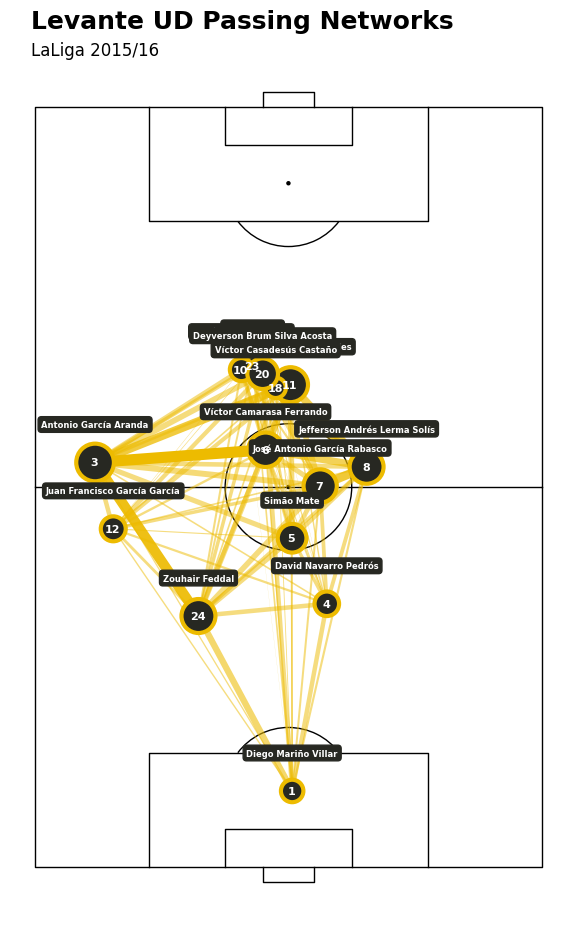

In [ ]:
pitch = VerticalPitch(pitch_type='statsbomb', line_color='black',linewidth=1,goal_type='box')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# plotar vertices
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size_degree, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax["pitch"], zorder = 3)

# Adicionar numero da camisa e nome do jogador
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x +6, row.y), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax["pitch"], zorder = 4,
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))

for i, row in scatter_df.iterrows():
    pitch.annotate(row.jersey_number, xy=(row.x, row.y-0.1), c='white', va='center',
                   ha='center', size=8, weight = "bold", ax=ax["pitch"], zorder = 4)

#Plotar bordas
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #média do local dos passes dados
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #largura da linha
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # Ajustar o alfa das linhas com base no número de passes e definir um alfa mínimo para um número menor de passes
        alpha = max(num_passes / lines_df['pass_count'].max(), 0.2)
        alpha = max(alpha, 0.5)
        #plotar linhas no campo
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax["pitch"])

fig.text(s=Team + " "+ "Passing Networks", x= 0.06, y= 1, fontsize=18,fontweight="bold")
fig.text(s='LaLiga 2015/16', x = 0.06, y=0.97, fontsize=12)
plt.show()

# Conclusões

In [ ]:
#Comparação de metricas gerais
metricas = {
    "Barcelona": {"density_ponderada": density_ponderada_barca, "average_path_length": average_path_length_barca},
    "Real Madrid": {"density_ponderada": density_ponderada_real, "average_path_length": average_path_length_real},
    "Atlético Madrid": {"density_ponderada": density_ponderada_atlet, "average_path_length": average_path_length_atlet},
    "Rayo Vallecano": {"density_ponderada": density_ponderada_rayo, "average_path_length": average_path_length_rayo},
    "Getafe": {"density_ponderada": density_ponderada_getafe, "average_path_length": average_path_length_getafe},
    "Levante UD": {"density_ponderada": density_ponderada_levante, "average_path_length": average_path_length_levante}
}
# Criar DataFrame
metricas = pd.DataFrame.from_dict(metricas, orient='index')
metricas

,density_ponderada,average_path_length
Barcelona,0.228199,136.351648
Real Madrid,0.174066,122.107843
Atlético Madrid,0.188194,140.395604
Rayo Vallecano,0.238539,125.309524
Getafe,0.185615,96.483516
Levante UD,0.293754,107.813187


## Métricas de rede
Por meio da comparação das métricas de rede pode-se concluir que a densidade da rede não segue um padrão claro que diferencia os melhores time dos piores. Porém, o comprimento médio do caminho é notavelmente menor nos dois piores times. O que pode ser indicativos que esses times recorrem mais a lançamentos longos e a bola não circula de forma organizada entre os jogadores.



## degree
Ao se comparar os gráficos plotados com o tamanho dos nós representando o valor do degree é possivel observar claramente que os melhores times tem vários jogadores com valores altos de degree enquanto os jogadores dos piores times tem degree muito mais baixo. O que mostra que os melhores times ficam mais com a bola, trocam mais passes e envolvem mais jogadores durante o jogo.

##Closeness
A conclusão ao se comparar os gráficos plotados com o tamanho dos nós representando o valor de proximidade é a mesma quando comparamos o comprimento médio do caminho.

##Betweenness
Ao se comparar os gráficos plotados com o tamanho dos nós representando o valor do Betweenness é possivel observar que nos melhores times mais jogadores possuem betweenness maior do que 0, ou seja, esses times tem mais "porteiros" da informação, o que dificulta a marcação, uma vez que se o time é muito dependente de um jogador para girar a bola é mais facil organizar a defesa ao redor desse jogador.